# All classes detections using OTB preprecessed channels with basic unet network

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS, TRAIN_DATA, TRAIN_LABEL_TILES
from image_utils import get_image_data, get_image_tile_data, normalize
from visu_utils import display_img_1b, display_labels

### Input data

In [4]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [5]:
from glob import glob
all_train_ids = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_ids = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_ids if 'mean' not in s and 'std' not in s])
print "First & last train ids : ", all_train_ids[0], all_train_ids[-1], len(all_train_ids)

First & last train ids :  6010_1_2 6170_4_1 25


In [6]:
from image_utils import imwrite, compute_mean_std_on_images
from geo_utils.GeoImage import GeoImage

ll = int(len(all_train_ids)*0.8)
train_ids = all_train_ids[:ll]
val_ids = all_train_ids[ll:]


feature_wise = True
s = ''
if feature_wise:
    s = "_feature_wise"

mean_fname = os.path.join(TRAIN_DATA, 'mean_image%s.tif' % s)
std_fname = os.path.join(TRAIN_DATA, 'std_image%s.tif' % s)
if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
    logging.getLogger().setLevel(logging.INFO)
    mean_image, std_image = compute_mean_std_on_images(train_ids, 'input')
    logging.getLogger().setLevel(logging.ERROR)
    imwrite(mean_fname, mean_image)
    imwrite(std_fname, std_image)
else:
    mean_image = GeoImage(mean_fname).get_data()
    std_image = GeoImage(std_fname).get_data()

print mean_image.shape, std_image.shape
print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
print len(train_ids), len(val_ids)

logging.getLogger().setLevel(logging.ERROR)

(3349, 3404, 17) (3349, 3404, 17)
-0.223745 709.406 0.0 87.0268
20 5


In [7]:
from data_utils import get_image_ids
from training_utils import tile_iterator

# def normalize_image(img_data, mean_image=None, std_image=None):
#     out = img_data.astype(np.float32)    
#     if mean_image is not None or std_image is not None:
#         out -= mean_image 
#         out /= std_image
#     out = out.transpose([2,0,1])
#     return out

def generate_images(image_ids_to_use, batch_size):
    while True:
        X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use,
                              channels,
                              labels, 
                              presence_percentage=10, 
                              tile_size=tile_size, 
                              mean_image=mean_image,
                              std_image=std_image
                             )
        counter = 0
        for x, y in tiles:     
            
            x = x.transpose([2,0,1])
            y = y.transpose([2,0,1])

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0

In [24]:
from training_utils import normalize_image


def get_XY_val(val_ids,                
               channels,
               labels,
               image_type='input', 
               label_type='label', 
               tile_size=(256, 256), 
               mean_image=None, 
               std_image=None):    
    ll = len(val_ids)
    n_channels = len(channels)
    n_labels = len(labels)
    
    size = [0, 0]
    for image_id in val_ids: 
        image_shape = get_image_data(image_id, image_type, return_shape_only=True)
        label_image_shape = get_image_data(image_id, label_type, return_shape_only=True)
        h = max(image_shape[0], label_image_shape[0])
        w = max(image_shape[1], label_image_shape[1])
        if h > size[0]:
            size[0] = h
        if w > size[1]:
            size[1] = w
            
    size = tuple(size)
    X = np.zeros((ll, n_channels)+size, dtype=np.float32)
    Y = np.zeros((ll, n_labels)+size, dtype=np.float32)
    
    if mean_image is not None and std_image is not None:
        if n_channels < mean_image.shape[2]:
            mean_image = mean_image[:,:,channels]
            std_image = std_image[:,:,channels]

    for i, image_id in enumerate(val_ids):
        image = get_image_data(image_id, image_type).astype(np.float32)
        label_image = get_image_data(image_id, label_type).astype(np.float32)
        
        if n_channels < image.shape[2]:
            image = image[:,:,channels]
        
        if n_labels < label_image.shape[2]:
            label_image = label_image[:,:,labels]
                
        if mean_image is not None and std_image is not None:
            image = normalize_image(image, mean_image, std_image)

        h, w, _ = image.shape
        hl, wl, _ = label_image.shape
        image = image.transpose([2,0,1])
        label_image = label_image.transpose([2,0,1])
        X[i,:,:h,:w] = image
        Y[i,:,:hl,:wl] = label_image
        
    return X, Y

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


In [14]:
shape = get_image_data(TRAIN_IMAGE_IDS[0], 'input', return_shape_only=True)

tile_size = (256, 256)
channels = np.array(range(shape[2]))
# channels = np.array([0, 1, 2, 3, 4])
n_channels = len(channels)

labels = np.array(range(1,len(LABELS)))
#labels = np.array([5, 6])
n_labels = len(labels)

In [15]:
channels, labels

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

(5, 17, 256, 256) (5, 10, 256, 256)
-8.22162 20.8747 0.0 1.0


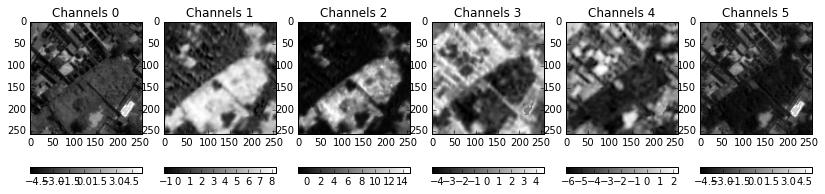

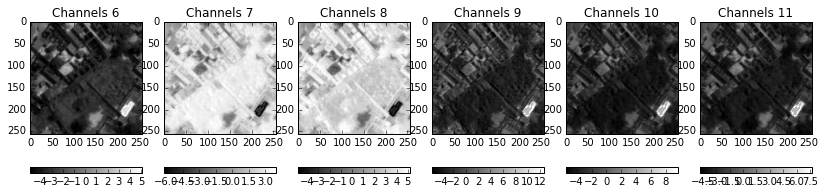

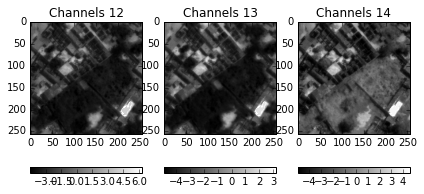

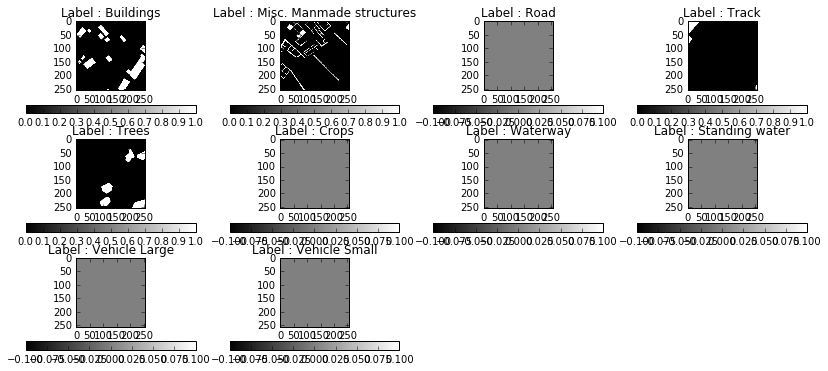

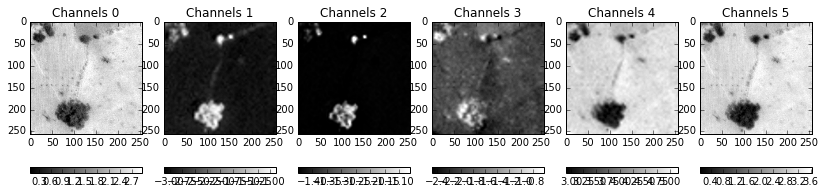

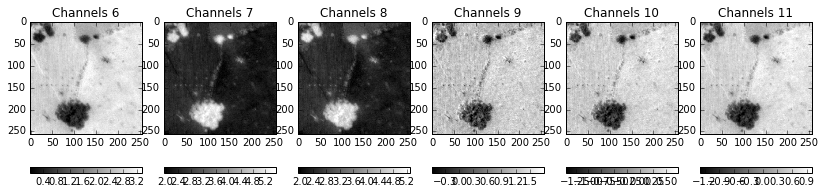

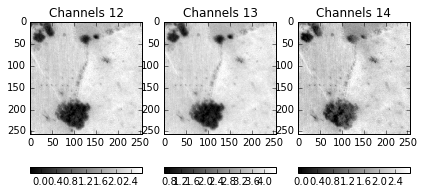

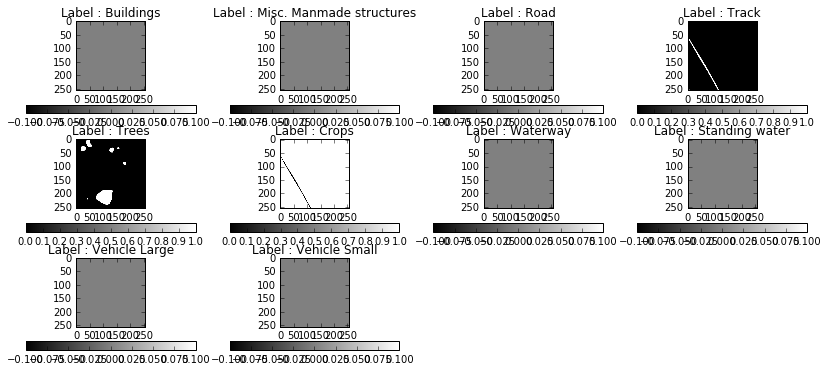

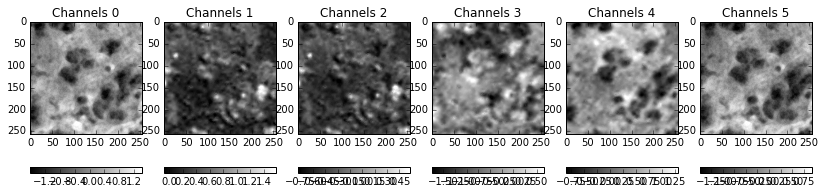

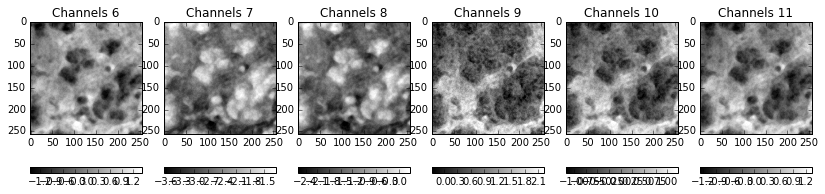

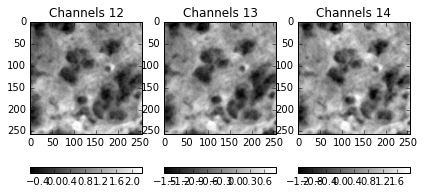

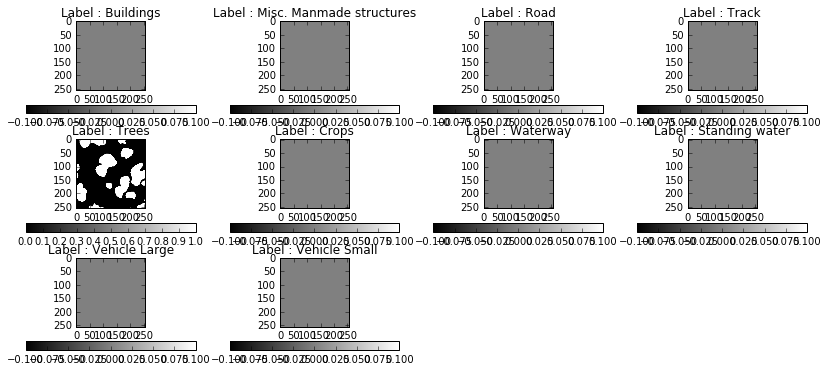

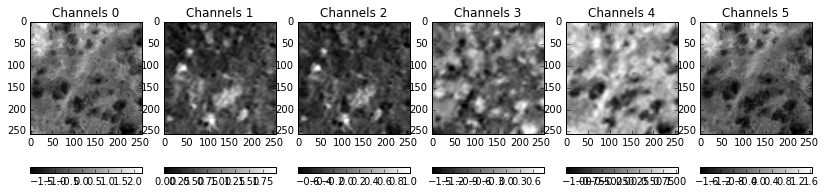

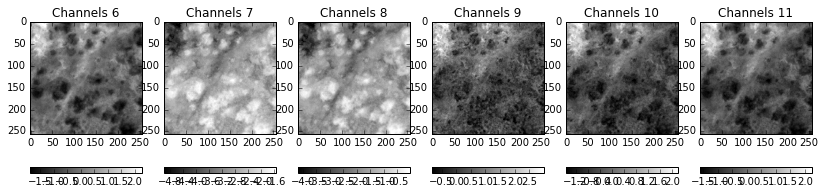

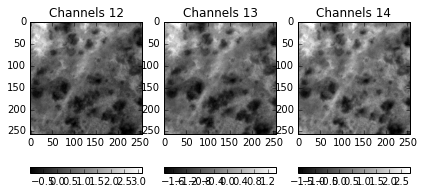

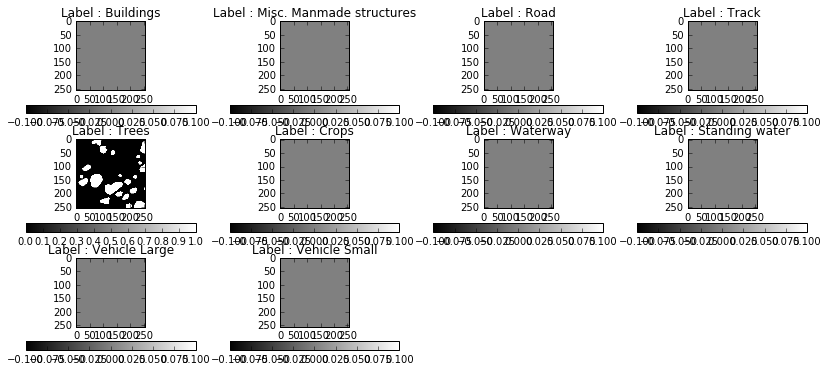

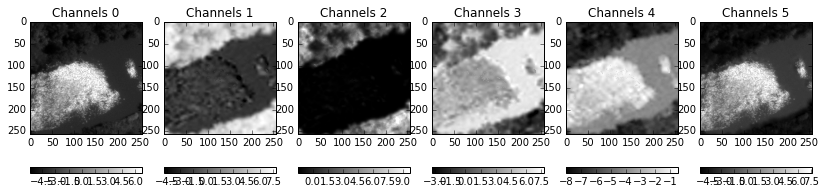

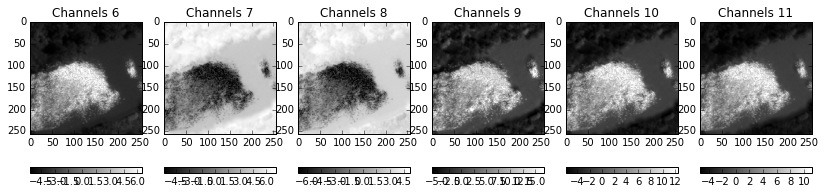

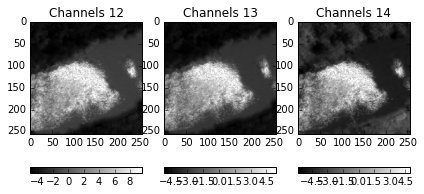

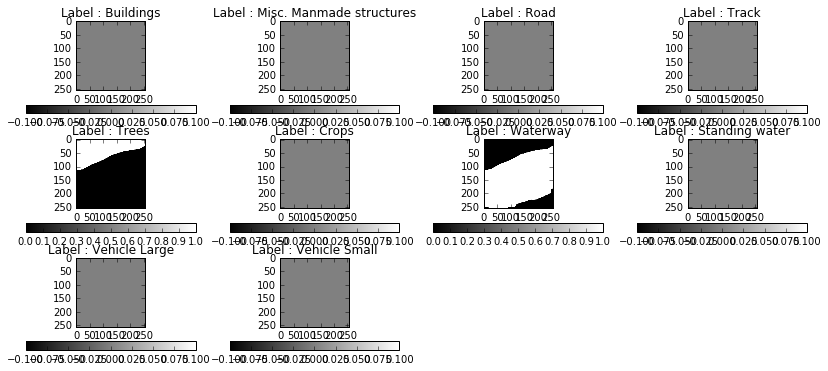

In [12]:
batch_size = 5
for X, Y in generate_images(train_ids, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        n, m = 3, int(_channels * 1.0 / 3.0 + 1.0)
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [25]:
X_val, Y_val = get_XY_val(val_ids, channels, labels, tile_size=tile_size, mean_image=mean_image, std_image=std_image)

In [26]:
print X_val.shape, X_val.dtype, X_val.min(), Y_val.max()
print Y_val.shape, Y_val.dtype, Y_val.min(), Y_val.max()

(5, 17, 3348, 3403)

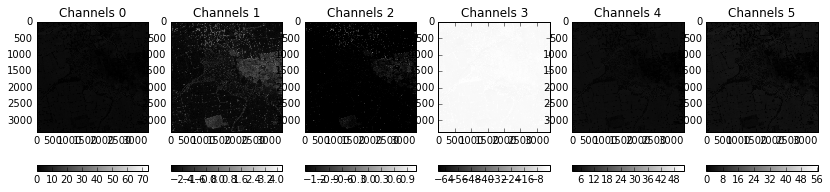

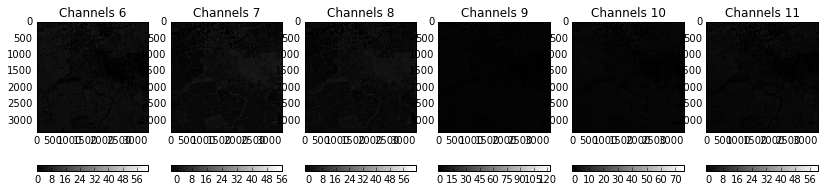

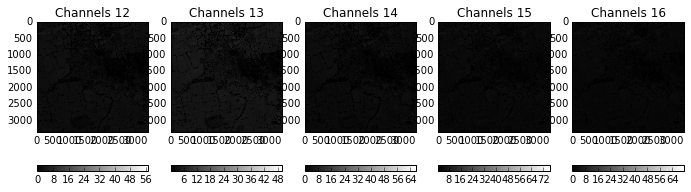

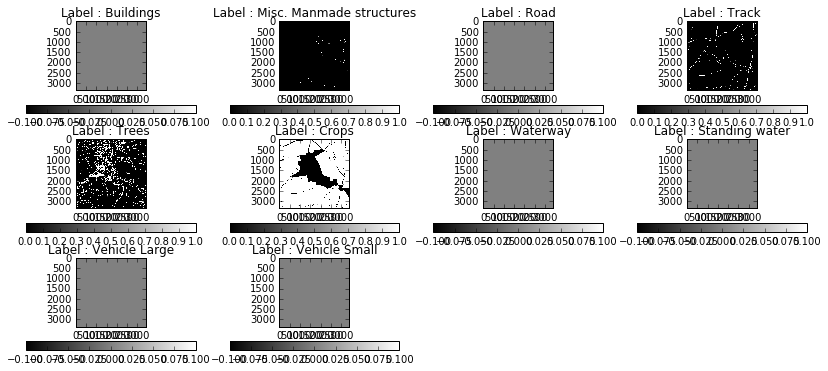

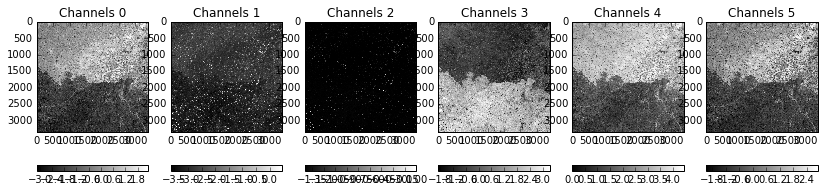

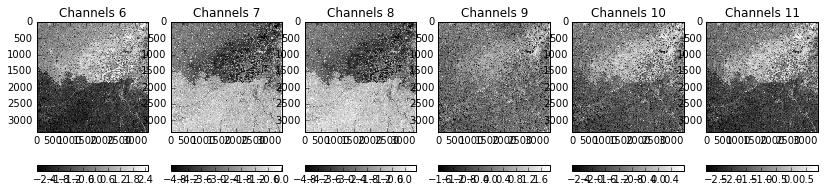

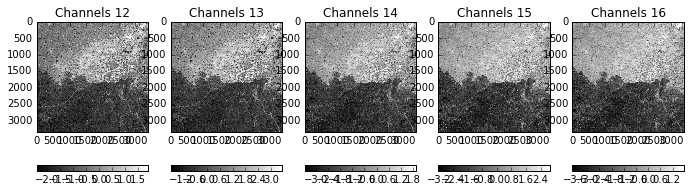

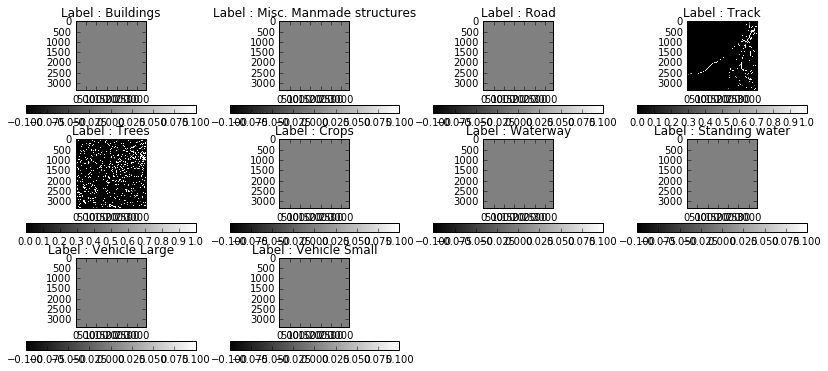

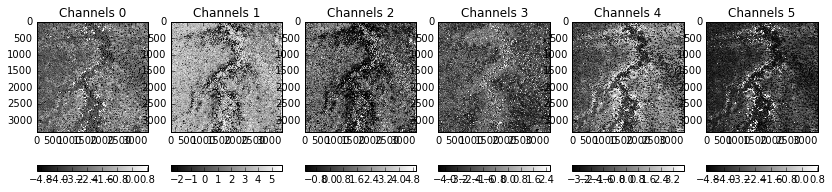

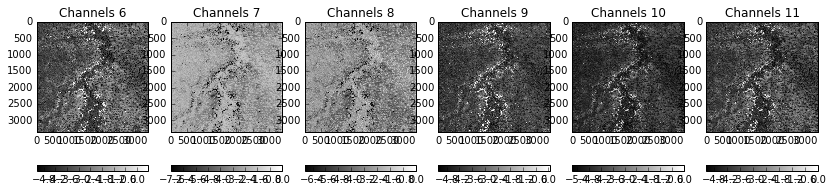

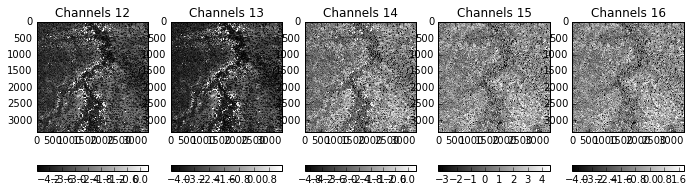

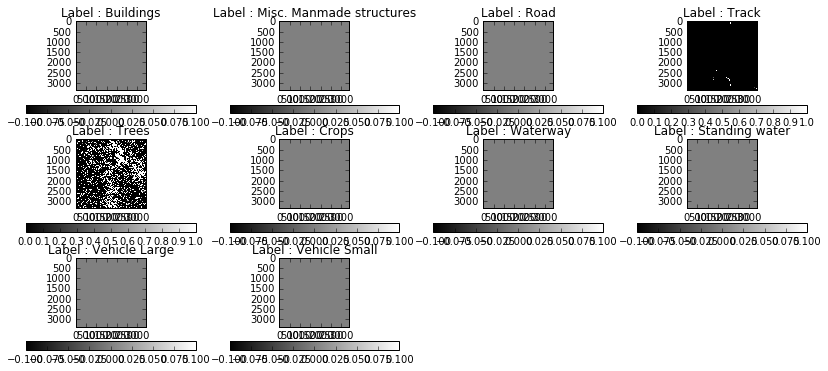

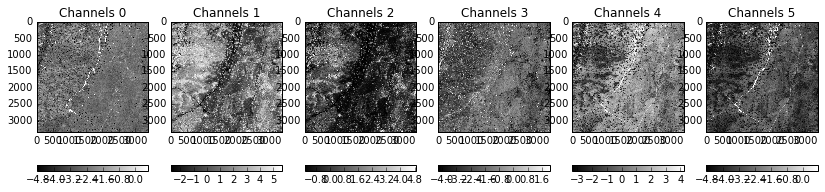

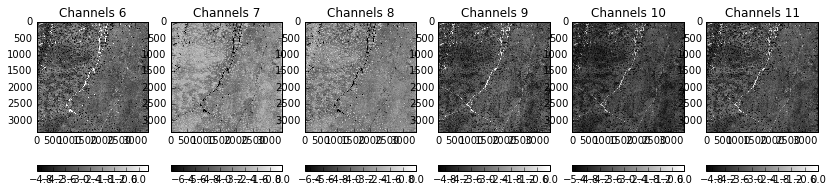

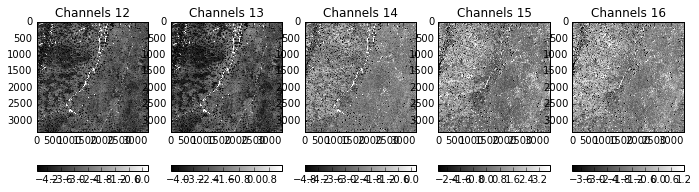

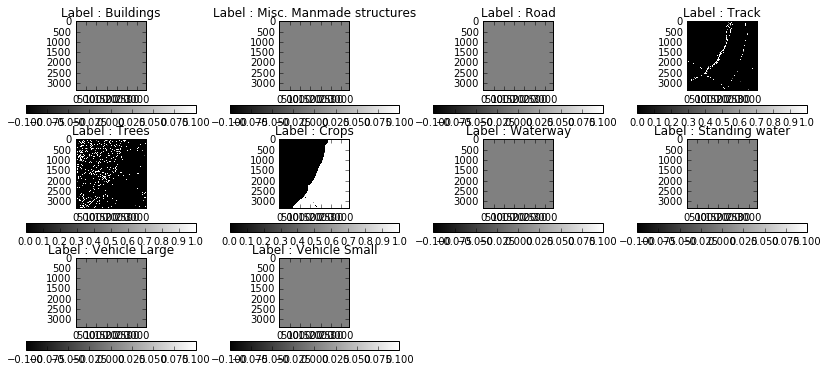

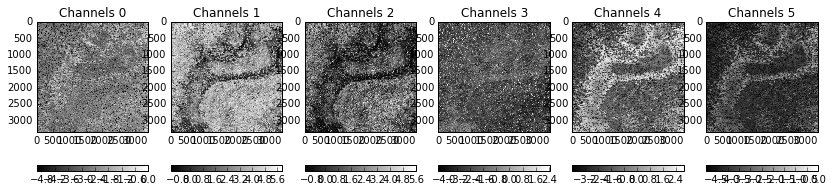

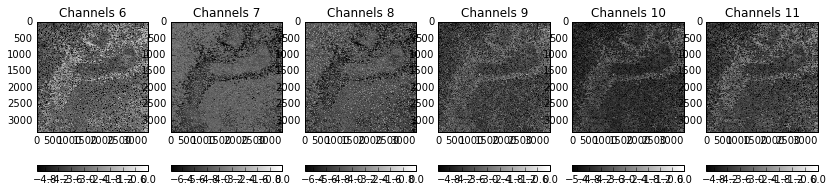

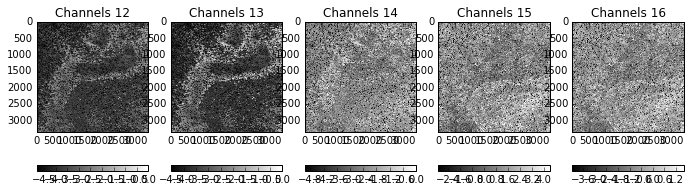

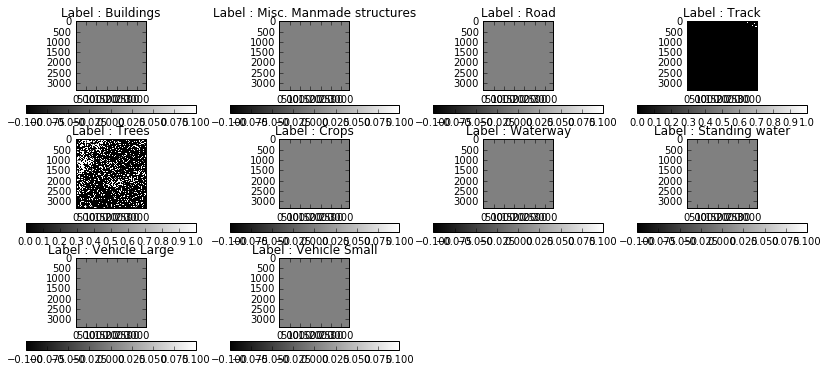

In [28]:
# for i in range(X_val.shape[0]):
#     _channels = X_val.shape[1]
#     n, m = 3, int(_channels * 1.0 / 3.0 + 1.0)
#     for j in range(_channels):
#         if j % m == 0:
#             plt.figure(figsize=(14, 4))                
#         plt.subplot(1,m,j % m +1)
#         display_img_1b(X_val[i,j,:,:])
#         plt.title("Channels %i" % j)

#     plt.figure(figsize=(14, 6))    
#     if n_labels < 8:
#         n, m = 1, n_labels
#     else:
#         n, m = 3, int(n_labels * 1.0 / 3.0 + 1.0), 
#     for j in range(n_labels):
#         plt.subplot(n, m,j+1)
#         display_img_1b(Y_val[i,j,:,:])
#         plt.title("Label : %s" % LABELS[labels[j]])


In [11]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from another_unet import unet

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5103)


In [12]:
model = unet(n_labels, n_channels, *tile_size)

weights_filename = os.path.join("weights", "another_unet_%i_%i.h5" % (n_channels, n_labels))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [13]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 17, 256, 256)  0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 128, 128)  9856        input_1[0][0]                    
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 64, 128, 128)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 128, 64, 64)   73856       leakyrelu_1[0][0]                
___________________________________________________________________________________________

In [14]:
from cgt_callbacks import CalcJaccard

if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
#earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

cgt_calc_jaccard = CalcJaccard()

# LearningRateScheduler

In [15]:
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In the neural network terminology:

- one epoch = one forward pass and one backward pass of all the training examples
    
- batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
    
- number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

In [19]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 1024
nb_val_samples = 256


print batch_size, samples_per_epoch, nb_val_samples
try:
    history = model.fit_generator(
        generate_images(train_ids, batch_size),
        samples_per_epoch=samples_per_epoch, 
        nb_epoch=50,
        validation_data=generate_images(val_ids, batch_size),
        nb_val_samples=nb_val_samples,
        callbacks=[model_checkpoint],
        verbose=1
    )
except KeyboardInterrupt:    
    model.save_weights(weights_filename)

4 1024 256
Epoch 1/50
1024/1024 [==============================] - 749s - loss: 0.0658 - jaccard_coef: 0.1643 - jaccard_coef_int: 0.1655 - recall: 0.5185 - precision: 0.7604 - val_loss: 0.1525 - val_jaccard_coef: 0.0399 - val_jaccard_coef_int: 0.0362 - val_recall: 0.2142 - val_precision: 0.4528
Epoch 2/50
1024/1024 [==============================] - 752s - loss: 0.0570 - jaccard_coef: 0.1263 - jaccard_coef_int: 0.1222 - recall: 0.4742 - precision: 0.7121 - val_loss: 0.1475 - val_jaccard_coef: 0.0382 - val_jaccard_coef_int: 0.0328 - val_recall: 0.1920 - val_precision: 0.4145
Epoch 3/50
1024/1024 [==============================] - 759s - loss: 0.0640 - jaccard_coef: 0.1529 - jaccard_coef_int: 0.1489 - recall: 0.4963 - precision: 0.7380 - val_loss: 0.1128 - val_jaccard_coef: 0.0526 - val_jaccard_coef_int: 0.0466 - val_recall: 0.2993 - val_precision: 0.4550
Epoch 4/50
1024/1024 [==============================] - 748s - loss: 0.0633 - jaccard_coef: 0.1549 - jaccard_coef_int: 0.1532 - recall

In [15]:
# plt.plot(history.history['val_jaccard_coef_int'])
# plt.ylabel('Jaccard coeff integer')
plt.plot(history.history['val_jaccard_coef'])
plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

In [25]:
batch_size = 5

for X, Y in generate_images(train_ids, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break

TypeError: tile_iterator() takes at least 3 arguments (6 given)

In [ ]:
from cgt_callbacks import calc_jacc


X_val, Y_val = get_XY_val(val_ids)

score, trs = calc_jacc(model, img=None, msk=None, range_thres=range(5, 10), batch_size=4)

In [24]:
batch_size = 5

for X, Y in generate_images(train_ids, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break

NameError: name 'train_tiles' is not defined

In [ ]:
_plot(X, Y, Y_pred, 0, 0)

In [ ]:
y = Y_pred[0,2,:,:]
print y.min(), y.max()